# Metagrating design and analysis

A polarization-insensitive metagrating based on propagation phase modulation mechanism is designed and analyzed.

## 0. Prepare

In [1]:
import importlib.util
# import lumapi
spec = importlib.util.spec_from_file_location('lumapi', 'D:\\Program Files\\Lumerical\\v241\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec)
spec.loader.exec_module(lumapi)

In [2]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# import custom modules
sys.path.append("../module")
from FieldPropagation import fieldPropagationLumapi, em_field
from MetaTool import nk2permittivity, setResources, phaseDis, phaseNorm, extendField

## 1. Constants, classes and functions

In [7]:
# colorbar setting
cmap_amp = "Reds"  # amplitude use
cmap_ang = "RdBu_r"  # angle (phase) use

In [8]:
def factor2pi(phi, near_zero=1e-9):
    """ 
    Solve the positive integer `x` to have: `x` * `phi` is an integer multiple of 2\pi
    @param phi: base number
    @param near_zero: numerical error to judge whether x` * `phi` is an integer multiple of 2\pi
    @return: `x`, an positive integer
    """
    x = 1
    while True:
        if np.abs((phi * x / np.pi) % 2) < near_zero or np.abs((phi * x / np.pi) % 2 - 2) < near_zero:
            break
        else:
            x += 1
    return x

## 2. Parameters

Here we design a polarization-insensitive metagrating along x-direction using the cylinder meta-atoms. 

In simulation, we use the x-polarized incident light.

In [12]:
# define destination phase profile
delta_phi = 2 / 5 * np.pi  # phase shift difference between adjacent meta-atoms
rows = 1  # row number of meta-atoms. Fix to 1
cols = factor2pi(delta_phi)  # column number of meta-atoms to realize 2*N*\pi phase change, where N is arbitrary positive integer 
phase_profile_dest = phaseNorm(np.arange(-np.pi, -np.pi + delta_phi * cols, delta_phi)).reshape((rows, cols))

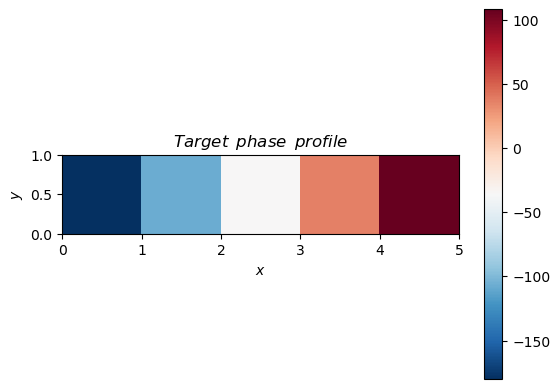

In [13]:
# draw the spatial phase profile
fig = plt.figure()
c = plt.pcolor(np.rad2deg(phase_profile_dest), cmap=cmap_ang)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("$Target \enspace phase \enspace profile$")
fig.colorbar(c)
plt.gca().set_aspect(1)
plt.show()

In [14]:
# parameters
# control parameters
hide = False  # whether to hide GUI or not

# spectral
wavelength_number = 1  # the number of discrete points of the spectral
wavelength = 633e-9  # operating wavelength [m]
wavelength_min = wavelength
wavelength_max = wavelength
source_polarization = np.deg2rad(0)  # the angle of polarization to the x axis [rad]

# metasurface hologram parameters
unit_size = 300e-9  # unit size [m]
units_rows = rows  # the number of rows of metasurface units
units_cols = cols  # the number of columns of metasurface units
offset_x = units_cols / 2 * unit_size - unit_size / 2  # the offset of metasurface in the x direction relative to the center
offset_y = units_rows / 2 * unit_size - unit_size / 2  # the offset of metasurface in the y direction relative to the center

# simulation objects
material_atom = "TiO2"
material_substrate = "Al2O3 - Palik"

separation = wavelength_max / 2  # safe spacing between the objects and simulation boundaries
sep_ub_t = separation  # spacing between upper bound and transmission plane
sep_t_atom = separation  # spacing between transmission plane and atom
sep_interface_source = separation * 0.5  # spacing between interface (atom / substrate) and source
sep_source_lb = separation * 0.5  # spacing between source and lower bound
height_atom = 500e-9  # [m]
height_substrate = separation * 2  # [m]. If 0, no substrate

# simulation size
sim_x_span = unit_size * units_cols
sim_y_span = unit_size * units_rows
sim_z_span = sep_ub_t + sep_t_atom + height_atom + sep_interface_source + sep_source_lb

# boundary conditions: PML / Period / Bloch / (Anti-)Symmetric
boundary_x_min = "Period"
boundary_x_max = "Period"
boundary_y_min = "Period"
boundary_y_max = "Period"
boundary_z_min = "PML"
boundary_z_max = "PML"

# mesh settings (automate mesh)
mesh_accuracy = 2

In [15]:
# solve diffraction angle of metagrating
diffraction_angle = np.arcsin((delta_phi / unit_size) * wavelength / (2 * np.pi))
print("Diffraction angle: {} (deg)".format(np.rad2deg(diffraction_angle)))

Diffraction angle: 24.960920385773164 (deg)


## 3. Arrangement of library meta-atoms

Here we use the propagation phase meta-atom library built by the notebook `PropagationPhaseMetasurface.ipynb`.

In [16]:
# load library
with open('../data/propagation_library.npy', 'rb') as f:
    radius_vec = np.load(f)
    phase_vec = np.load(f)
    t_vec = np.load(f)

In [17]:
def fom(phase_dest, phase, t):
    """ 
    Figure of merit 
    """
    tolerance_phase = np.deg2rad(5)  # phase error we can tolerate considering solving accuracy
    lambda_phase = 2e0  # weight for phase item
    lambda_t = 1e0  # weight for transmittance item
    return phaseDis(phase, phase_dest) * (phaseDis(phase, phase_dest) > tolerance_phase) * lambda_phase + \
        (-1) * t * lambda_t

In [18]:
# sort phase and make dictionary of index and order
phase_sort_vec = sorted(enumerate(phase_vec), key=lambda x:x[1])
index_order_dict = {phase_sort_vec[i][0]: i for i in range(len(phase_sort_vec))}
order_index_dict = {i: phase_sort_vec[i][0] for i in range(len(phase_sort_vec))}

In [19]:
# choose suitable meta-atom from library
units_pos_r_dict = {}  # dictionary for metasurface units (position and radius)
for i in range(units_rows):
    for j in range(units_cols):
        phase_dest = phase_profile_dest[i, j]
        matched = False
        tolerance = np.deg2rad(15)
        while not matched:
            index_begin = 0
            index_end = len(phase_sort_vec) - 1
            # special cases
            if phase_sort_vec[index_end][1] <= phase_dest - tolerance:
                index_begin = index_end
            elif phase_sort_vec[index_begin][1] >= phase_dest + tolerance:
                index_end = index_begin
            # general case
            else:
                while phase_sort_vec[index_begin][1] < phase_dest - tolerance:
                    index_begin += 1
                while phase_sort_vec[index_end][1] > phase_dest + tolerance:
                    index_end -= 1

            if index_end < index_begin:
                # not matched
                tolerance *= 2
            else:
                # range: [index_begin, index_end]
                fom_min = np.inf
                index_lib_best = 0
                for ii in range(index_begin, index_end + 1, 1):
                    index = order_index_dict[ii]
                    fom_current = fom(phase_dest, phase_vec[index], t_vec[index])
                    if fom_current < fom_min:
                        fom_min = fom_current
                        index_lib_best = index
                units_pos_r_dict[(i, j)] = radius_vec[index_lib_best]
                matched = True

## 4. Simulation

In [20]:
# open fdtd
fdtd = lumapi.FDTD(hide=hide)
print(">> Progress: FDTD is opened.")

>> Progress: FDTD is opened.


In [21]:
# add material
material_name = "TiO2"
material_df = pd.read_csv("../material/TiO2.csv")
material_np = np.array(material_df)
# obtain the frequency array
wavelength_array = material_np[:, 0] * 1e-6  # [m]
frequency_array = fdtd.c() / wavelength_array
# obtain the complex permittivity array from (n, k)
permittivity_array = nk2permittivity(material_np[:, 1], material_np[:, 2])
# combine
sampled_data = np.vstack((frequency_array, permittivity_array)).T
# add
temp = fdtd.addmaterial("Sampled data")
fdtd.setmaterial(temp, "name", material_name)  # rename the material
fdtd.setmaterial(material_name, "max coefficients", 6)  # set the number of coefficients
fdtd.setmaterial(material_name, "color", np.array([255 / 255, 69 / 255, 0 / 255, 1]))
fdtd.setmaterial(material_name, "sampled data", sampled_data)
print(">> Progress: Adding material " + material_name + " is done.")

>> Progress: Adding material TiO2 is done.


In [22]:
# resource settings 
parallel_job_number = 1
processes = 2
threads = 1
capacity = 1
job_launching_preset = "Remote: Intel MPI"  # "Remote: Microsoft MPI" / "Remote: Intel MPI"

setResources(fdtd, parallel_job_number=parallel_job_number, processes=processes, \
    threads=threads, capacity=capacity, job_launching_preset=job_launching_preset)

In [23]:
# define basic objects
# make sure in layout mode
if fdtd.layoutmode() != 1:  # layoutmode() return 0 when in analysis mode
    fdtd.switchtolayout()

fdtd.deleteall()  # clear objects

# source
source = fdtd.addplane(
    name="source",
    # size
    x=0,
    x_span=sim_x_span,
    y=0,
    y_span=sim_y_span,
    z=-sep_interface_source,
    # propagation direction
    injection_axis="z",
    direction="forward",
    angle_theta=0,
    angle_phi=0,
    amplitude=1,
    # polarization direction
    polarization_angle=np.rad2deg(source_polarization),
    # phase
    phase=0,
    # bandwidth
    wavelength_start=wavelength_min,
    wavelength_stop=wavelength_max,
)

# FDTD
sim_region = fdtd.addfdtd(
    dimension="3D",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z_min=-(sep_interface_source + sep_source_lb),
    z_max=height_atom + sep_t_atom + sep_ub_t,
    # boundary condition
    x_min_bc=boundary_x_min,
    x_max_bc=boundary_x_max,
    y_min_bc=boundary_y_min,
    y_max_bc=boundary_y_max,
    z_min_bc=boundary_z_min,
    z_max_bc=boundary_z_max,
    pml_layers=8,
    auto_shutoff_min=1e-5,
    mesh_accuracy=mesh_accuracy
)

# monitor
fdtd.setglobalmonitor("frequency points", wavelength_number)  # global settings
power_profile_t = fdtd.addpower(
    name="power profile T",
    monitor_type="2D Z-normal",
    x=0.0,
    x_span=sim_x_span,
    y=0.0,
    y_span=sim_y_span,
    z=height_atom + sep_t_atom,
)

# substrate
substrate = fdtd.addrect(
    name="substrate",
    x=0.0, 
    y=0.0,
    x_span=sim_x_span,
    y_span=sim_y_span,
    z_max=0,
    z_min=-height_substrate,
    material=material_substrate
)
# meta-atoms
atoms = []
for pos in units_pos_r_dict:
    x = pos[1] * unit_size - offset_x
    y = pos[0] * unit_size - offset_y
    radius = units_pos_r_dict[pos]
    atoms.append(fdtd.addcircle(
        name="atom_" + str(pos[0]) + "/" + str(pos[1]),
        x=x,
        y=y,
        radius=radius,
        z_min=0,
        z_max=height_atom,
        material=material_atom
    ))

In [24]:
fdtd.save("../fsp/metagrating.fsp")  # save simulation

In [25]:
t1 = time.perf_counter()  # begin time count
fdtd.run()  # run
t2 = time.perf_counter()  # end time count
print("Run time cost: {}s.".format(t2 - t1))

Run time cost: 17.21160350000001s.


## 5. Near field analysis

In [26]:
# obtain data
mesh_x_vec = fdtd.getdata(power_profile_t.name, 'x')[:, 0]
mesh_y_vec = fdtd.getdata(power_profile_t.name, 'y')[:, 0]
power_profile_t_e = fdtd.getresult(power_profile_t.name, 'E')
e_t_x_mat = power_profile_t_e['E'][:, :, 0, 0, 0]
e_t_y_mat = power_profile_t_e['E'][:, :, 0, 0, 1]
e_t_z_mat = power_profile_t_e['E'][:, :, 0, 0, 2]
t = fdtd.getresult(power_profile_t.name, 'T')['T'][0]

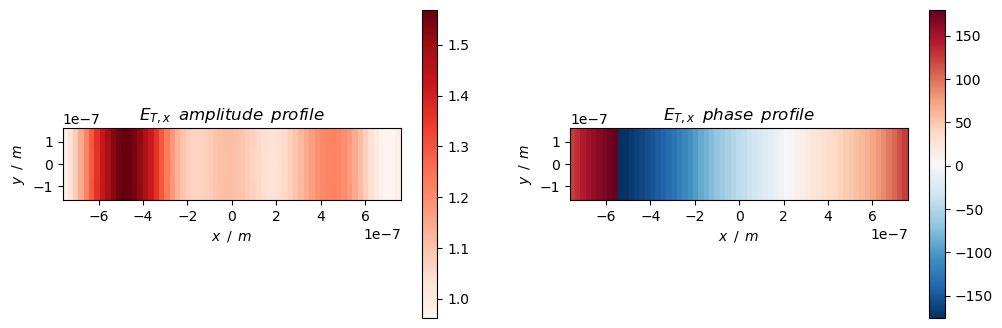

In [27]:
# draw the near field distribution
sep = 1  # sample the dense monitor data

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = plt.pcolor(
    mesh_x_vec[::sep],
    mesh_y_vec[::sep],
    np.abs(e_t_x_mat[::sep, ::sep]).T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{T, x} \enspace amplitude \enspace profile$")
plt.axis("scaled")

plt.subplot(1, 2, 2)
c = plt.pcolor(
    mesh_x_vec[::sep],
    mesh_y_vec[::sep],
    np.rad2deg(np.angle(e_t_x_mat[::sep, ::sep])).T, 
    cmap=cmap_ang
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{T, x} \enspace phase \enspace profile$")
plt.axis("scaled")
plt.show()

In [28]:
t

0.9064910398107868

## 6. Far field analysis

Here we calculate the diffraction pattern on the observation plane.

In [29]:
# extend the period near field to practical finite size
extend_x = 10  # extend number on the x-direction
extend_y = 30  # extend number on the x-direction
print("x: {} um".format((unit_size * units_cols * extend_x) * 1e6))
print("y: {} um".format((unit_size * units_rows * extend_y) * 1e6))

x: 15.0 um
y: 9.0 um


In [30]:
# define destination region (observation plane)
observe_z = 1  # z of the observation plane [m]
observe_x_half_span = 1.5  # half span of the observation plane along x [m]
observe_y_half_span = 0.1  # half span of the observation plane along y [m]
dest_x_vec = np.linspace(-observe_x_half_span, observe_x_half_span, 161)
dest_y_vec = np.linspace(-observe_y_half_span, observe_y_half_span, 21)

# extend field
x_extend_vec, y_extend_vec, e_extend_mat, h_extend_mat = extendField(
    mesh_x_vec, mesh_y_vec, 
    fdtd.getresult(power_profile_t.name, 'E')['E'], fdtd.getresult(power_profile_t.name, 'H')['H'], 
    unit_size * units_cols, unit_size * units_rows, extend_x, extend_y
)

# define near field
near_field = em_field(
    [wavelength],
    x_extend_vec,
    y_extend_vec,
    [0],
    e_extend_mat,
    h_extend_mat
)

# solve far field
# # no down sampling
# fdtd.farfieldsettings("override near field mesh", False)
# down samplint
fdtd.farfieldsettings("override near field mesh", True)  # down sample the near field to speed up far field projections
fdtd.farfieldsettings("near field samples per wavelength", 4)  # if 2, at Nyquist limit

e_far_field_observe = fieldPropagationLumapi(near_field, dest_x_vec, dest_y_vec, \
    [observe_z], wavelength_index_vec=np.arange(0, 1), fdtd=fdtd)
e_far_field_observe_x = e_far_field_observe[:, :, 0, 0, 0]
e_far_field_observe_y = e_far_field_observe[:, :, 0, 1, 0]
e_far_field_observe_z = e_far_field_observe[:, :, 0, 2, 0]
e_far_field_focal_intensity = np.abs(e_far_field_observe_x) ** 2 + np.abs(e_far_field_observe_y) ** 2 + np.abs(e_far_field_observe_z) ** 2

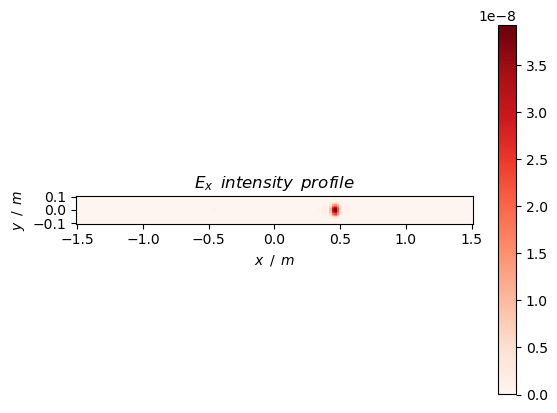

In [31]:
# Ex intensity on the observation plane
fig = plt.figure()
c = plt.pcolor(
    dest_x_vec, dest_y_vec, 
    (np.abs(e_far_field_observe_x) ** 2).T, 
    cmap=cmap_amp
)
fig.colorbar(c)
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$y \enspace / \enspace m$")
plt.title(r"$E_{x} \enspace intensity \enspace profile$")
plt.axis("scaled")
plt.show()

In [32]:
# solve the destination x position for the diffracted light
x_dest = observe_z * np.tan(diffraction_angle)
print("Destination x position: {} m".format(x_dest))

Destination x position: 0.4654775433242962 m


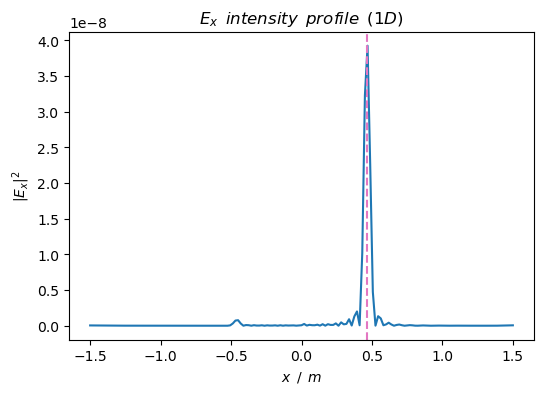

In [33]:
# 1D profile of the diffraction pattern
plt.figure(figsize=(6, 4))
plt.plot(dest_x_vec, (np.abs(e_far_field_observe_x[:, round(len(dest_y_vec) / 2)]) ** 2))
plt.axvline(x_dest, linestyle="--", color="tab:pink")
plt.xlabel(r"$x \enspace / \enspace m$")
plt.ylabel(r"$|E_x|^2$")
plt.title(r"$E_{x} \enspace intensity \enspace profile \enspace (1D)$")
plt.show()

In [ ]:
# # close FDTD
# fdtd.close()